# **Sessa Empirical Estimator**

## A. Setup

### I. Import Libraries and Set Paths

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# DBScan Libraries
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

CSV_PATH = './csv-files/'

### II. Setup data

In [15]:
file_path = CSV_PATH + "med_events.csv"

# Try to read the CSV file into a DataFrame
try:
    med_events = pd.read_csv(file_path)
    print("CSV file loaded successfully!")
    
    # Convert date column to datetime (assuming 'DATE' is the column name in your CSV)
    med_events["DATE"] = pd.to_datetime(med_events["DATE"])

    # Change column names
    med_events.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

    # Display the first few rows
    print(med_events.head())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Ensure the file exists.")



CSV file loaded successfully!
   pnr       eksd  perday   ATC  dur_original
0    1 2033-04-26       4  medA            50
1    1 2033-07-04       4  medB            30
2    1 2033-08-03       4  medB            30
3    1 2033-08-17       4  medB            30
4    1 2033-10-13       4  medB            30


## B. Callable Functions

### I. SEE Using **K-Means**

In [16]:
def see(arg1):
    # Filter dataset for the selected medication
    subset = med_events[med_events["ATC"] == arg1].copy()
    
    # Sort and create a previous prescription date column
    subset = subset.sort_values(["pnr", "eksd"]).copy()
    subset["prev_eksd"] = subset.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    subset = subset.dropna().copy()
    
    # Compute event interval (time difference)
    subset["event_interval"] = (subset["eksd"] - subset["prev_eksd"]).dt.days

    # Remove non-positive event intervals
    subset = subset[subset["event_interval"] > 0].copy()

    if subset.empty:
        print("No valid data after filtering.")
        return pd.DataFrame()

    # Sort full dataset
    sorted_intervals_full = np.sort(subset["event_interval"])
    
    # Find 80% cutoff
    cutoff_value = sorted_intervals_full[int(0.8 * len(sorted_intervals_full))]
    
    # Create 80% dataset (excluding top 20% of values)
    subset_80 = subset[subset["event_interval"] <= cutoff_value].copy()

    # Compute ECDF values
    def compute_ecdf(data):
        sorted_data = np.sort(data)
        ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        return sorted_data, ecdf_y

    x_full, y_full = compute_ecdf(sorted_intervals_full)
    x_80, y_80 = compute_ecdf(subset_80["event_interval"])

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot ECDF for 100% data
    axes[0].plot(x_80, y_80, marker="o", linestyle="-", markersize=3, color="blue")
    axes[0].set_title("ECDF (80% Data)")
    axes[0].set_xlabel("Event Interval (days)")
    axes[0].set_ylabel("Cumulative Probability")
    axes[0].grid(True)

    # Plot ECDF for 80% data
    axes[1].plot(x_full, y_full, marker="o", linestyle="-", markersize=3, color="red")
    axes[1].set_title("ECDF (100% Data)")
    axes[1].set_xlabel("Event Interval (days)")
    axes[1].set_ylabel("Cumulative Probability")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return subset


### II. SEE Using **DBSCAN**

In [17]:
def see_dbscan(arg1):
    # Filter dataset for the selected medication
    subset = med_events[med_events["ATC"] == arg1].copy()
    
    # Sort and create a previous prescription date column
    subset = subset.sort_values(["pnr", "eksd"]).copy()
    subset["prev_eksd"] = subset.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    subset = subset.dropna().copy()
    
    # Select one random record per patient
    subset = subset.groupby("pnr").sample(n=1, random_state=1234).copy()

    # Compute event interval (time difference)
    subset["event_interval"] = (subset["eksd"] - subset["prev_eksd"]).dt.days

    # Remove non-positive event intervals
    subset = subset[subset["event_interval"] > 0].copy()

    # Compute ECDF
    if subset.empty:
        return pd.DataFrame()  # Return empty DataFrame if no valid data
    
    sorted_intervals = np.sort(subset["event_interval"])
    ecdf_y = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

    # Keep only the lower 80% of ECDF
    max_val = sorted_intervals[int(0.8 * len(sorted_intervals))]
    subset_filtered = subset[subset["event_interval"] <= max_val].copy()

    # Ensure subset_filtered is not empty
    if subset_filtered.empty:
        return pd.DataFrame()  # Return empty DataFrame if no valid data
    
    # Remove non-positive values before applying log
    subset_filtered = subset_filtered[subset_filtered["event_interval"] > 0]

    # Density plot of log-transformed event intervals
    if len(subset_filtered) > 1:  # Ensure there's enough data for KDE
        kde = gaussian_kde(np.log(subset_filtered["event_interval"]))
        x_vals = np.linspace(min(np.log(subset_filtered["event_interval"])), 
                             max(np.log(subset_filtered["event_interval"])), 100)
        y_vals = kde(x_vals)
    else:
        return pd.DataFrame()  # Return empty DataFrame if insufficient data for KDE

    # Normalize the data for clustering
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(subset_filtered[["event_interval"]])

    # Determine the optimal epsilon (eps) using k-distance method
    if len(scaled_data) < 5:
        return pd.DataFrame()  # Return empty DataFrame if not enough data for DBSCAN
    
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(scaled_data)
    distances, _ = neigh.kneighbors(scaled_data)
    k_distances = np.sort(distances[:, -1])  # Take the 5th neighbor distance

    # Choose eps as the "knee" point (approximation: 90th percentile of distances)
    eps_value = np.percentile(k_distances, 90)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    subset_filtered.loc[:, "cluster"] = dbscan.fit_predict(scaled_data)

    # Handle noise points (DBSCAN assigns -1 to noise)
    subset_filtered.loc[subset_filtered["cluster"] == -1, "cluster"] = np.nan

    # Cluster summary
    cluster_summary = subset_filtered.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()

    # Merge clusters back to main dataset
    results = subset_filtered.merge(cluster_summary, on="cluster", how="left")
    results = results[(results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"])]

    # Assign cluster to all data
    final_result = med_events[med_events["ATC"] == arg1].copy()
    final_result = final_result.merge(results[["pnr", "median", "cluster"]], on="pnr", how="left")

    # Fill missing cluster values safely
    final_result["cluster"] = final_result["cluster"].fillna(0)
    final_result["median"] = final_result["median"].fillna(results["median"].median())

    return final_result


### III. SEE Assumption

In [18]:
def see_assumption(data):
    data = data.copy()
    
    # Sort and create previous prescription date column
    data.sort_values(["pnr", "eksd"], inplace=True)
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    data = data.dropna()
    
    # Compute duration between prescriptions
    data["duration"] = (data["eksd"] - data["prev_eksd"]).dt.days
    
    # Assign sequence number per patient
    data["p_number"] = data.groupby("pnr").cumcount() + 1
    
    # Filter only patients with at least 2 prescriptions
    data = data[data["p_number"] >= 2]
    
    # Select only the needed columns
    Drug_see2 = data[['pnr', 'eksd', 'prev_eksd', 'p_number', 'duration']]

    # Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='duration', data=Drug_see2)
    plt.title("Duration Between Prescriptions")
    plt.xlabel("Prescription Number")
    plt.ylabel("Duration (days)")
    
    # Compute median of medians per patient
    medians_of_medians = Drug_see2.groupby("pnr")["duration"].median()
    
    # Overlay median line for overall median duration
    plt.axhline(medians_of_medians.median(), color="red", linestyle="dashed", label='Overall Median')
    plt.legend()
    plt.show()

    return Drug_see2  # Optionally return the processed DataFrame

### IV. Plotting Functions

## C. Execution

### I. SEE Using **K-Means**

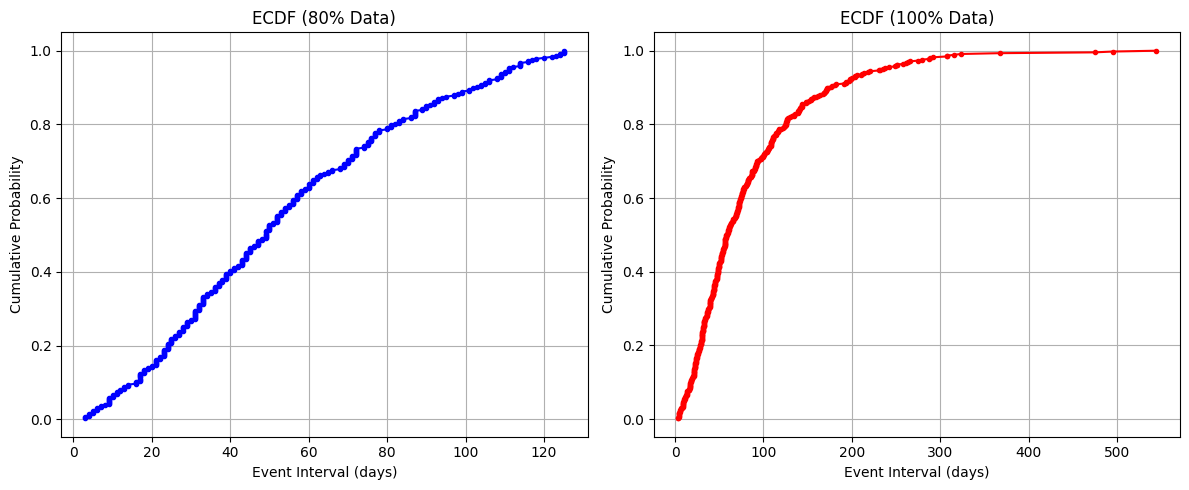

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval
25,2,2036-03-10,4,medA,50,2036-01-20,50
26,2,2036-08-01,4,medA,50,2036-03-10,144
61,4,2032-11-27,4,medA,50,2032-05-01,210
62,4,2033-08-20,4,medA,50,2032-11-27,266
63,4,2033-08-30,4,medA,50,2033-08-20,10
...,...,...,...,...,...,...,...
1056,98,2034-02-25,4,medA,50,2034-01-02,54
1057,98,2034-12-10,4,medA,50,2034-02-25,288
1060,99,2032-06-16,4,medA,50,2031-11-08,221
1062,99,2032-09-18,4,medA,50,2032-06-16,94


In [19]:
med_a = see("medA")
med_a

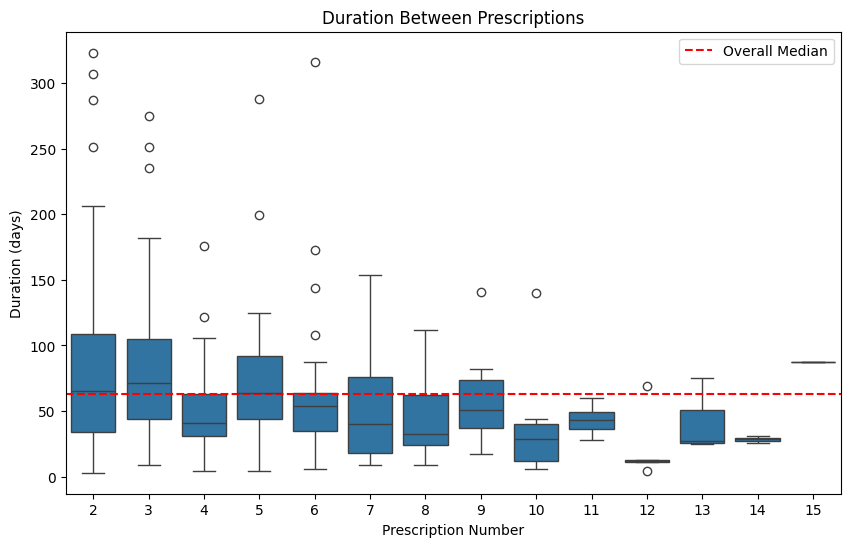

,pnr,eksd,prev_eksd,p_number,duration
63,4,2033-08-30,2033-08-20,2,10
64,4,2033-12-17,2033-08-30,3,109
69,5,2032-03-04,2032-01-25,2,39
70,5,2032-09-02,2032-03-04,3,182
71,5,2032-12-17,2032-09-02,4,106
...,...,...,...,...,...
1028,96,2043-05-07,2043-04-17,10,20
1054,98,2033-09-14,2033-06-16,2,90
1055,98,2034-01-02,2033-09-14,3,110
1056,98,2034-02-25,2034-01-02,4,54


In [20]:
see_assumption(med_a)

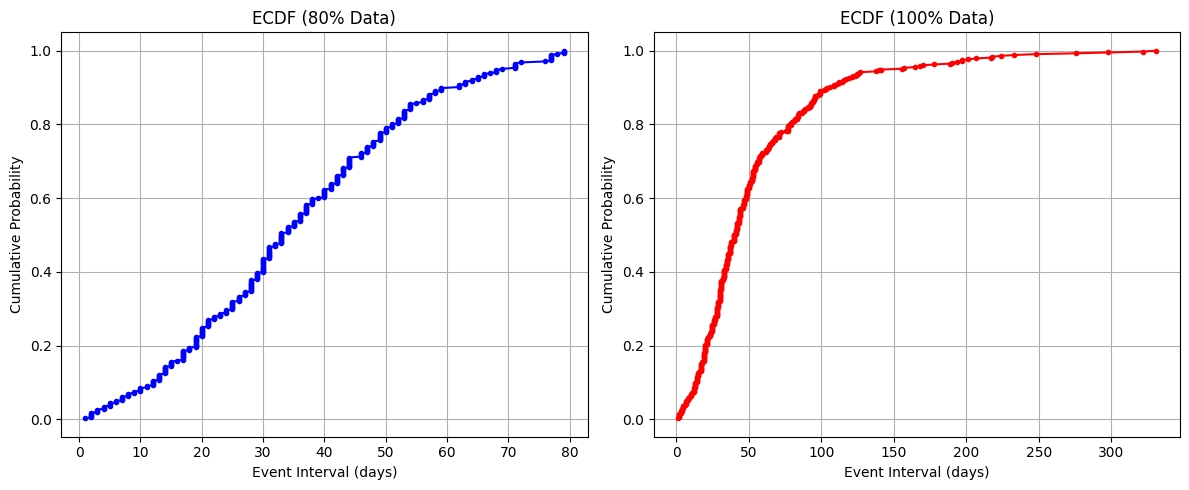

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval
2,1,2033-08-03,4,medB,30,2033-07-04,30
3,1,2033-08-17,4,medB,30,2033-08-03,14
4,1,2033-10-13,4,medB,30,2033-08-17,57
5,1,2033-10-16,4,medB,30,2033-10-13,3
6,1,2033-11-23,4,medB,30,2033-10-16,38
...,...,...,...,...,...,...,...
1075,100,2034-03-05,6,medB,30,2034-01-22,42
1076,100,2034-04-07,6,medB,30,2034-03-05,33
1077,100,2034-04-26,6,medB,30,2034-04-07,19
1078,100,2034-05-26,6,medB,30,2034-04-26,30


In [21]:
med_b = see("medB")
med_b

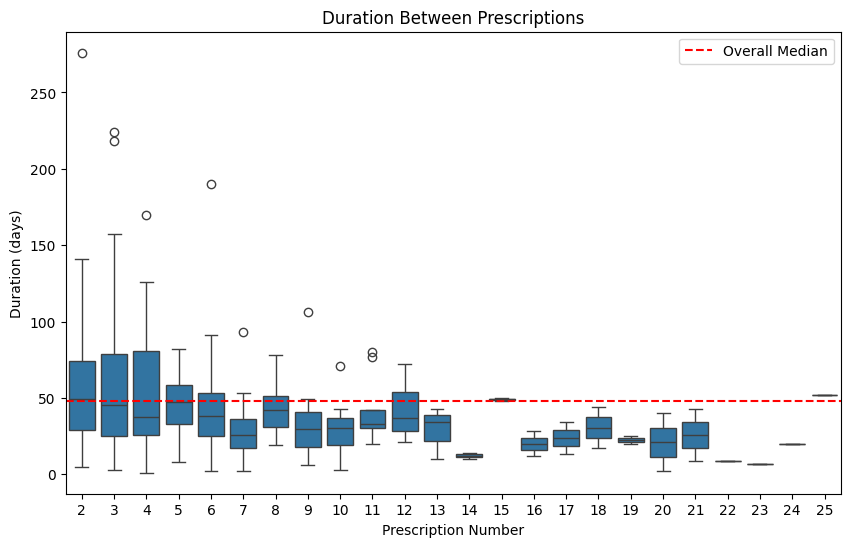

,pnr,eksd,prev_eksd,p_number,duration
4,1,2033-10-13,2033-08-17,2,57
5,1,2033-10-16,2033-10-13,3,3
6,1,2033-11-23,2033-10-16,4,38
7,1,2034-01-19,2033-11-23,5,57
8,1,2034-02-08,2034-01-19,6,20
...,...,...,...,...,...
1075,100,2034-03-05,2034-01-22,8,42
1076,100,2034-04-07,2034-03-05,9,33
1077,100,2034-04-26,2034-04-07,10,19
1078,100,2034-05-26,2034-04-26,11,30


In [22]:
see_assumption(med_b)

### II. SEE Using **DBSCAN**

In [23]:
med_a_DB = see_dbscan("medA")
med_a_DB

,pnr,eksd,perday,ATC,dur_original,median,cluster
0,1,2033-04-26,4,medA,50,44.0,0.0
1,2,2036-01-20,4,medA,50,44.0,0.0
2,2,2036-03-10,4,medA,50,44.0,0.0
3,2,2036-08-01,4,medA,50,44.0,0.0
4,3,2042-04-13,4,medA,50,44.0,0.0
...,...,...,...,...,...,...,...
544,99,2031-11-08,4,medA,50,44.0,0.0
545,99,2032-06-16,4,medA,50,44.0,0.0
546,99,2032-09-18,4,medA,50,44.0,0.0
547,100,2032-08-05,2,medA,150,44.0,0.0


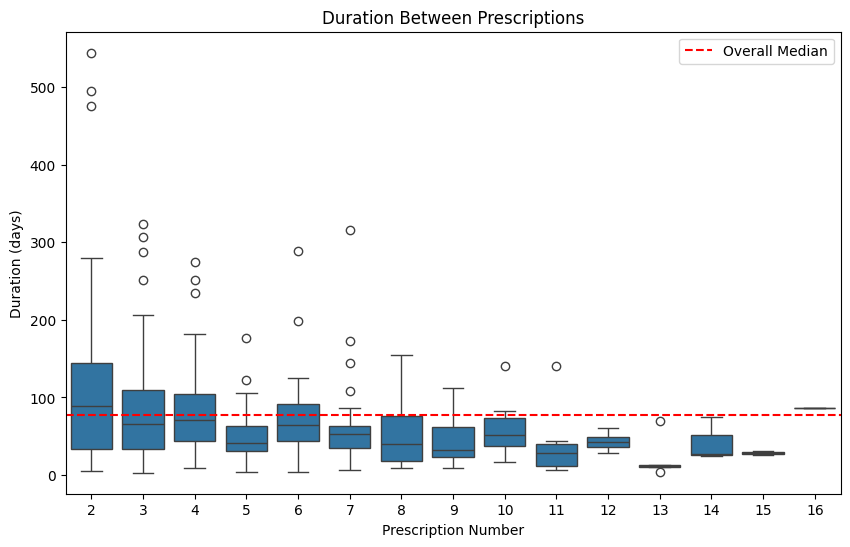

,pnr,eksd,prev_eksd,p_number,duration
3,2,2036-08-01,2036-03-10,2,144
7,4,2033-08-20,2032-11-27,2,266
8,4,2033-08-30,2033-08-20,3,10
9,4,2033-12-17,2033-08-30,4,109
12,5,2032-01-25,2031-12-27,2,29
...,...,...,...,...,...
540,98,2033-09-14,2033-06-16,3,90
541,98,2034-01-02,2033-09-14,4,110
542,98,2034-02-25,2034-01-02,5,54
543,98,2034-12-10,2034-02-25,6,288


In [24]:
see_assumption(med_a_DB)

In [25]:
med_b_DB = see_dbscan("medB")
med_b_DB

,pnr,eksd,perday,ATC,dur_original,median,cluster
0,1,2033-07-04,4,medB,30,34.0,0.0
1,1,2033-08-03,4,medB,30,34.0,0.0
2,1,2033-08-17,4,medB,30,34.0,0.0
3,1,2033-10-13,4,medB,30,34.0,0.0
4,1,2033-10-16,4,medB,30,34.0,0.0
...,...,...,...,...,...,...,...
526,100,2034-03-05,6,medB,30,34.0,0.0
527,100,2034-04-07,6,medB,30,34.0,0.0
528,100,2034-04-26,6,medB,30,34.0,0.0
529,100,2034-05-26,6,medB,30,34.0,0.0


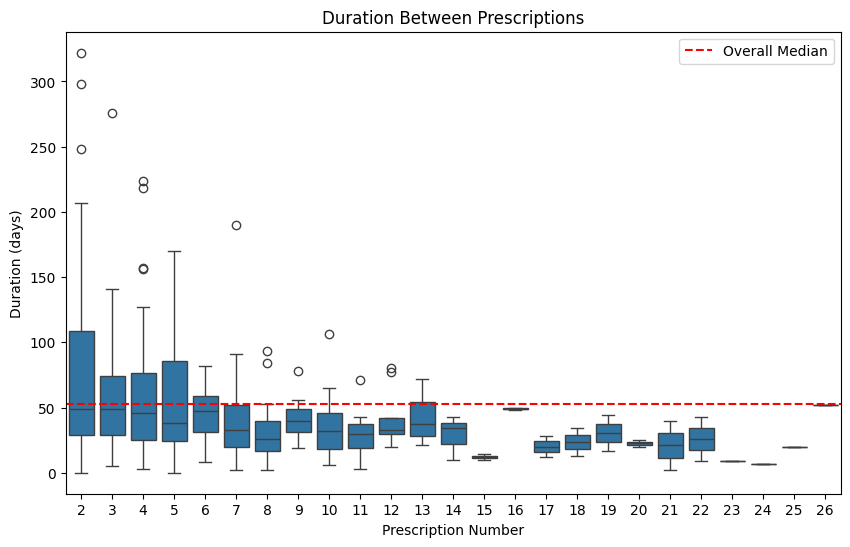

,pnr,eksd,prev_eksd,p_number,duration
2,1,2033-08-17,2033-08-03,2,14
3,1,2033-10-13,2033-08-17,3,57
4,1,2033-10-16,2033-10-13,4,3
5,1,2033-11-23,2033-10-16,5,38
6,1,2034-01-19,2033-11-23,6,57
...,...,...,...,...,...
526,100,2034-03-05,2034-01-22,9,42
527,100,2034-04-07,2034-03-05,10,33
528,100,2034-04-26,2034-04-07,11,19
529,100,2034-05-26,2034-04-26,12,30


In [26]:
see_assumption(med_b_DB)


## **Comparison: SEE + KMeans vs. SEE + DBSCAN**

### **A. Early Prescription Variability**
#### **SEE + KMeans:**
- Early prescriptions (low p_number) show **wide refill interval distributions**.
- Some outliers extend **beyond 400–500 days** for medA and **~300 days** for medB.
- KMeans forces every data point into a cluster, potentially **blending irregular patterns** with typical ones.

#### **SEE + DBSCAN:**
- Similar early variability, but **DBSCAN isolates extreme refill outliers as noise**.
- More clearly differentiates between **patients with stable refill patterns and those with irregular behavior**.
- Results in a **sharper view of typical refill behavior** compared to KMeans.

### **B. Convergence in Later Prescriptions**
#### **SEE + KMeans:**
- **medA:** Stabilization around p_number **10**, with durations narrowing to **50–70 days**.
- **medB:** Convergence around p_number **15–20**, settling at **20–60 days**.
- Shows a **clear pattern of patients stabilizing refill behavior over time**.

#### **SEE + DBSCAN:**
- **medA:** Identifies up to **26 prescription events**, revealing more nuanced patterns.
- **medB:** Later refills show **similar stability**, but DBSCAN segments **subgroups within stable behavior**.
- Detects **subtle differences in refill consistency** beyond what KMeans reveals.

### **C. Differences Between medA and medB**
#### **Number of Prescriptions (Boxplots)**
- **KMeans:**
  - medA: **Up to 17** prescriptions observed.
  - medB: **Up to 27**, indicating longer treatment or frequent refills.
- **DBSCAN:**
  - medA: **Detects 26 prescription events**, uncovering **hidden refill patterns**.
  - medB: Similar number of refills as KMeans but **better noise filtering**.

#### **Duration Ranges & Median Refill Intervals**
- **KMeans:**
  - medA: Outliers reach **500 days early on**, stabilizing to **~50–60 days** later.
  - medB: Outliers up to **300 days**, stabilizing to **~30–40 days**.
- **DBSCAN:**
  - Excludes extreme outliers as noise, refining the typical refill patterns.
  - medB median remains **~30–40 days**, but DBSCAN isolates **clusters with different refill behaviors**.

### **D. Key Insights & Implications**
#### **Early Refill Irregularity**
- Both methods confirm **high variability in early refills**.
- **KMeans** blends outliers into clusters, while **DBSCAN isolates them as noise**, giving a clearer picture of adherence issues.

#### **Stabilization Over Time**
- Refill intervals become more predictable as p_number increases.
- **DBSCAN provides finer stratification**, revealing **subtle differences in long-term refill behaviors**.

#### **Different Refill Patterns by Medication**
- **medA:** DBSCAN identifies more **granular refill clusters**, suggesting **complex refill patterns**.
- **medB:** Fewer refills overall but **higher early variability**, requiring different adherence strategies.

#### **Clinical & Operational Implications**
- **For KMeans:** Useful for a **generalized, structured view of refill trends**.
- **For DBSCAN:** Detects **irregular patterns and adherence risks**, making it useful for **early intervention strategies**.
- **Tailored interventions**: DBSCAN’s noise filtering could help identify patients who need **reminders, counseling, or support**.

### **Final Thoughts**
- **SEE + KMeans** is better for a **simplified, fixed-cluster view** of refill behavior.
- **SEE + DBSCAN** provides **richer segmentation** by isolating **outliers and subtle subgroups**.
- **Choice depends on whether simplicity or detailed adherence patterns are the priority**.
